1. Calculating QPM period from design parameters...
   - Calculated QPM Period: 7.2017 μm
   - Number of Domains: 555
   - Actual Device Length: 1998.46 μm

2. Building uniform grating and running CWES simulator...
3. Calculating theoretical spectrum via NPDA (sinc^2)...
4. Plotting comparison...


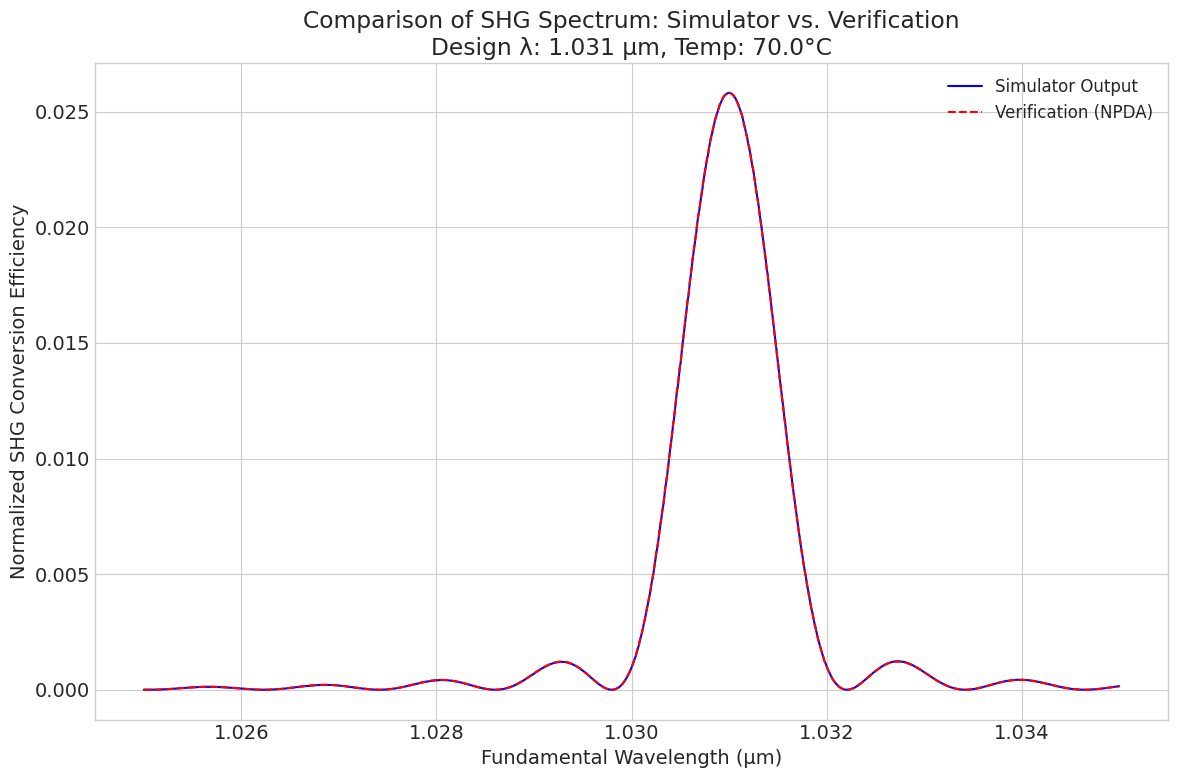

In [23]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import jit, vmap

from qpm import cwes, grating, mgoslt

CORRECTION_FACTOR = 1.07 / 2.84 * 100


def calc_dk_pairs(wls: jnp.ndarray, temp: float) -> jnp.ndarray:
    delta_k1_values = mgoslt.calc_twm_delta_k(wls, wls, temp)
    delta_k2_values = mgoslt.calc_twm_delta_k(wls, wls / 2, temp)
    return jnp.stack([delta_k1_values, delta_k2_values], axis=1)


def compute_shg_spectrum(superlattice: jnp.ndarray, dk_pairs: jnp.ndarray) -> jnp.ndarray:
    b_initial = jnp.array([1.0, 0.0, 0.0], dtype=jnp.complex64)

    def _simulate_single_point(dk_pair: jnp.ndarray) -> jnp.ndarray:
        """Simulates for a single wavelength point."""
        delta_k1, delta_k2 = dk_pair[0], dk_pair[1]
        b_final = cwes.simulate_twm(superlattice, delta_k1, delta_k2, b_initial)
        return jnp.abs(b_final[1]) ** 2

    vmapped_simulation = vmap(_simulate_single_point)
    return jit(vmapped_simulation)(dk_pairs)


def calculate_verification_spectrum(
    wavelengths: jnp.ndarray,
    device_length: float,
    kappa_mag: float,
    design_temp: float,
    design_wavelength: float,
) -> jnp.ndarray:
    """
    Calculates the theoretical SHG spectrum using the sinc^2 formula (NPDA).
    This serves as an analytical verification for the simulator.
    """
    # The grating vector Kg is fixed by the phase matching condition at the design point.
    k_g = mgoslt.calc_twm_delta_k(design_wavelength, design_wavelength, design_temp)

    # Calculate the material's phase mismatch across the entire wavelength spectrum.
    delta_k_material = mgoslt.calc_twm_delta_k(wavelengths, wavelengths, design_temp)

    # The total phase mismatch is the difference between the material's mismatch and the grating's.
    delta_k_total = delta_k_material - k_g

    # Standard formula for SHG efficiency in the low-conversion (non-depleted pump) limit.
    sinc_squared_part = jnp.sinc(delta_k_total * device_length / (2 * jnp.pi)) ** 2
    efficiency_raw = (kappa_mag**2) * (device_length**2) * sinc_squared_part

    # Apply a specific correction factor mentioned in the context, potentially for Gaussian beam effects.
    return efficiency_raw * CORRECTION_FACTOR


def main() -> None:
    """Main function to run the simulation, verification, and plot the comparison."""
    # --- Parameters ---
    device_length = 2000.0  # Target total length of the device (μm)
    kappa_mag = 1.31e-5  # Nonlinear coupling coefficient magnitude (μm⁻¹)
    design_temp = 70.0  # QPM design temperature (°C)
    design_wavelength = 1.031  # QPM design wavelength (μm)
    num_points = 1000  # Resolution of the spectrum
    wl_start, wl_end = 1.025, 1.035  # Wavelength range for simulation (μm)

    # --- Setup ---
    print("1. Calculating QPM period from design parameters...")
    shg_delta_k_design = mgoslt.calc_twm_delta_k(design_wavelength, design_wavelength, design_temp)
    shg_qpm_period = 2 * jnp.pi / shg_delta_k_design
    print(f"   - Calculated QPM Period: {shg_qpm_period:.4f} μm")

    # Determine domain count and the actual, discretized device length.
    num_domains = int(jnp.round(2 * device_length / shg_qpm_period))
    actual_device_length = num_domains * shg_qpm_period / 2
    print(f"   - Number of Domains: {num_domains}")
    print(f"   - Actual Device Length: {actual_device_length:.2f} μm")

    wavelengths = jnp.linspace(wl_start, wl_end, num_points)

    # --- Simulator Calculation ---
    print("\n2. Building uniform grating and running CWES simulator...")
    profile = grating.uniform_profile(num_domains, shg_qpm_period, kappa_mag)
    superlattice = grating.build(profile)
    dk_pairs = calc_dk_pairs(wavelengths, design_temp)
    simulator_effs = compute_shg_spectrum(superlattice, dk_pairs)
    simulator_effs = simulator_effs * CORRECTION_FACTOR / (2 / jnp.pi) ** 2

    # --- Verification Calculation (NPDA) ---
    print("3. Calculating theoretical spectrum via NPDA (sinc^2)...")
    verification_effs = calculate_verification_spectrum(wavelengths, actual_device_length, kappa_mag, design_temp, design_wavelength)

    # --- Plotting Results ---
    print("4. Plotting comparison...")
    plt.figure(figsize=(12, 8))

    plt.plot(wavelengths, simulator_effs, "b-", label="Simulator Output")
    plt.plot(wavelengths, verification_effs, "r--", label="Verification (NPDA)")

    plt.xlabel("Fundamental Wavelength (μm)")
    plt.ylabel("Normalized SHG Conversion Efficiency")
    plt.title(f"Comparison of SHG Spectrum: Simulator vs. Verification\nDesign λ: {design_wavelength} μm, Temp: {design_temp}°C")
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()


main()